In [1]:
from perses.analysis import utils
from openmmtools.multistate import MultiStateReporter, MultiStateSamplerAnalyzer
from simtk import unit
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from perses.analysis import utils

from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MultiStateReporter2(MultiStateReporter):
    def read_energies(self, iteration=slice(None)):
        """Retrieve the energy matrix at the given iteration on the analysis file
        Parameters
        ----------
        iteration : int or slice
            The iteration(s) at which to read the data. The slice(None) allows fetching all iterations at once.
        Returns
        -------
        energy_thermodynamic_states : n_replicas x n_states numpy.ndarray
            ``energy_thermodynamic_states[iteration, i, j]`` is the reduced potential computed at
            SamplerState ``sampler_states[iteration, i]`` and ThermodynamicState ``thermodynamic_states[iteration, j]``.
        energy_neighborhoods : n_replicas x n_states numpy.ndarray
            energy_neighborhoods[replica_index, state_index] is 1 if the energy was computed for this state,
            0 otherwise
        energy_unsampled_states : n_replicas x n_unsampled_states numpy.ndarray
            ``energy_unsampled_states[iteration, i, j]`` is the reduced potential computed at SamplerState
            ``sampler_states[iteration, i]`` and ThermodynamicState ``unsampled_thermodynamic_states[iteration, j]``.
        """
        # Determine last consistent iteration
        iteration = self._map_iteration_to_good(iteration)
        # Retrieve energies at all thermodynamic states
        energy_thermodynamic_states = np.array(self._storage_analysis.variables['energies'][iteration, :, :], np.float64)
        # Retrieve neighborhoods, assuming global neighborhoods if reading a pre-neighborhoods file
        try:
            energy_neighborhoods = np.array(self._storage_analysis.variables['neighborhoods'][iteration, :, :], 'i1')
        except KeyError:
            energy_neighborhoods = np.ones(energy_thermodynamic_states.shape, 'i1')
        # Read energies at unsampled states, if present
#         try:
#             energy_unsampled_states = np.array(self._storage_analysis.variables['unsampled_energies'][iteration, :, :], np.float64)
#         except KeyError:
#             # There are no unsampled thermodynamic states.
        unsampled_shape = energy_thermodynamic_states.shape[:-1] + (0,)
        energy_unsampled_states = np.zeros(unsampled_shape)
        return energy_thermodynamic_states, energy_neighborhoods, energy_unsampled_states


In [3]:
# Given a path, get dg and ddg
def analyze(path):
    reporter = MultiStateReporter(path)
    analyzer = MultiStateSamplerAnalyzer(reporter)
    f_ij, df_ij = analyzer.get_free_energy()
    f = f_ij[0,-1] # units = kT
#     f = f_ij[0,-1] * analyzer.kT
#     dg = f.in_units_of(unit.kilocalories_per_mole)
    df = df_ij[0, -1]
#     df = df_ij[0, -1] * analyzer.kT
#     ddg = df.in_units_of(unit.kilocalories_per_mole)
    return f, df

def analyze_dom(path):
    reporter = MultiStateReporter2(path)
    ncfile = utils.open_netcdf(path)
    n_iterations = ncfile.variables['last_iteration'][0]
    print(f"n_iterations: {n_iterations}")
    dg, ddg = list(), list()
#     iterations_to_analyze = list(range (1, n_iterations, 500)) + [int(n_iterations-1)]
#     print(iterations_to_analyze) # check that this is giving me the last avail iteration
#     for step in iterations_to_analyze: 
#         analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=step)
#         f_ij, df_ij = analyzer.get_free_energy()
#         dg.append(f_ij[0,-1])
#         ddg.append(df_ij[0,-1])
    # Get final free energy
    analyzer = MultiStateSamplerAnalyzer(reporter, max_n_iterations=n_iterations)
    f_ij, df_ij = analyzer.get_free_energy()
    dg.append(f_ij[0,-1])
    ddg.append(df_ij[0,-1])
    return np.array(dg), np.array(ddg), f_ij, df_ij

### 5 ns N501Y (repex/32/1/0)

In [4]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [5]:
main_dir = 32
sub_dir = 1
chunk = 0
titles = ['N501Y']

In [6]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [7]:
f_ij.shape

(12, 12)

In [8]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


0 apo: 10.143411137127146 (0.014483430607293969) kT



In [9]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/1)

In [10]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [11]:
main_dir = 32
sub_dir = 1
chunk = 1
titles = ['N501Y']

In [12]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [13]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


1 apo: 8.95908933472075 (0.040027620025350395) kT



In [14]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/2)

In [15]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [16]:
main_dir = 32
sub_dir = 1
chunk = 2
titles = ['N501Y']

In [17]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [18]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


2 apo: 7.350397332820017 (0.012470296329689746) kT



In [19]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/3)

In [20]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [21]:
main_dir = 32
sub_dir = 1
chunk = 3
titles = ['N501Y']

In [22]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [23]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


3 apo: 5.477888257659256 (0.010262732098177723) kT



In [24]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/4)

In [25]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [26]:
main_dir = 32
sub_dir = 1
chunk = 4
titles = ['N501Y']

In [27]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [28]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


4 apo: 3.6894177522956157 (0.008091335363521282) kT



In [29]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/5)

In [30]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [31]:
main_dir = 32
sub_dir = 1
chunk = 5
titles = ['N501Y']

In [32]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [33]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


5 apo: -24.416929025208894 (0.011283304384558273) kT



In [45]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/6)

In [46]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [47]:
main_dir = 32
sub_dir = 1
chunk = 6
titles = ['N501Y']

In [48]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [49]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


6 apo: -28.3842951491777 (0.0193329618395058) kT



In [50]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/7)

In [51]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [52]:
main_dir = 32
sub_dir = 1
chunk = 7
titles = ['N501Y']

In [53]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [54]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


7 apo: -29.822048641341244 (0.02461595235001973) kT



In [55]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/8)

In [56]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [57]:
main_dir = 32
sub_dir = 1
chunk = 8
titles = ['N501Y']

In [58]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [59]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


8 apo: -31.925231359880513 (0.02833559344897939) kT



In [60]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

### 5 ns N501Y (repex/32/1/9)

In [61]:
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [62]:
main_dir = 32
sub_dir = 1
chunk = 9
titles = ['N501Y']

In [63]:
output_dir = f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/'

print("analyzing apo")
apo_path = os.path.join(output_dir, f"{chunk}_apo.nc")
apo_dg, apo_ddg, f_ij, df_ij = analyze_dom(apo_path)

results = np.array([apo_dg, apo_ddg])
with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy', 'wb') as f:
    np.save(f, results)

with open(f'/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/f_ij_apo.npy', 'wb') as f:
    np.save(f, f_ij)

analyzing apo
n_iterations: 5000


In [64]:
# Read the dicts in and compute free energies (kT)
d_results = {}
with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{chunk}/results_apo.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)
    d_results[chunk] = results
    apo_dg, apo_ddg = [result[-1] for result in results]
    print(f"{chunk} apo: {apo_dg} ({apo_ddg}) kT")
    print()


9 apo: -30.869150891085017 (0.025688108548556694) kT



In [65]:
# Generate replica mixing plots
path = f"/data/chodera/zhangi/perses_benchmark/repex/32/{sub_dir}/{chunk}/{chunk}_apo.nc"
utils.plot_replica_mixing(path, title=f"{titles[0]} apo replicate {chunk}", filename=f"{path[:-3]}_replicas.png")
plt.clf()


<Figure size 1080x1728 with 0 Axes>

# Get complex free energy 

In [66]:
chunk_free_energies = []
chunk_errors = []
chunk_matrices = []
for i in range(10):
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{i}/results_apo.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)
        apo_dg, apo_ddg = [result[-1] for result in results]
        chunk_free_energies.append(apo_dg)
        chunk_errors.append(apo_ddg)
        
    with open(f"/data/chodera/zhangi/perses_benchmark/repex/{main_dir}/{sub_dir}/{i}/f_ij_apo.npy", "rb") as f:
        f_ij = np.load(f, allow_pickle=True)
        chunk_matrices.append(f_ij)

In [67]:
chunk_free_energies

[10.143411137127146,
 8.582741605120415,
 7.350397332820017,
 5.477888257659256,
 3.6894177522956157,
 -24.416929025208894,
 -28.3842951491777,
 -29.822048641341244,
 -31.925231359880513,
 -30.869150891085017]

In [68]:
np.sum(chunk_free_energies)

-110.17379898167091

In [69]:
np.sum(chunk_free_energies)*KT_KCALMOL

-65.68135275810461

In [70]:
error_sum_squares = 0
for error in chunk_errors:
    error_sum_squares += error**2
np.sqrt(error_sum_squares)*KT_KCALMOL

0.034458698634470396

In [71]:
import matplotlib.pyplot as plt

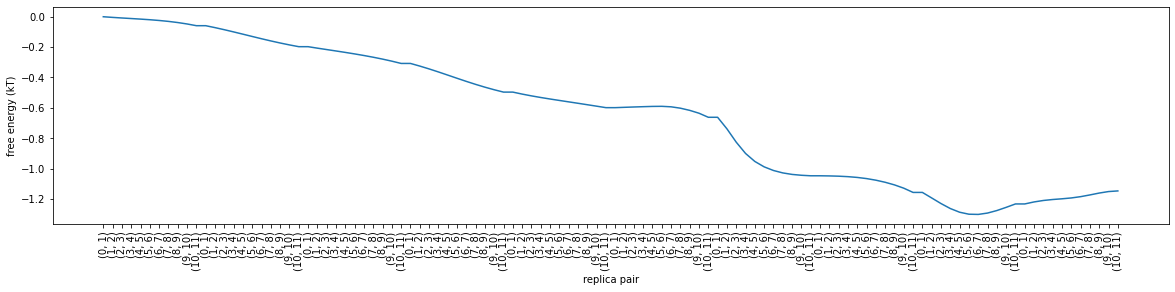

In [72]:
pairs = []
to_plot = []
last_replica_pair_offset = 0
for chunk in range(10):
    first_replica_pair_offset = chunk_matrices[chunk][0][1]
    for replica in range(11):
        pairs.append((replica, replica + 1))
        free_energy = chunk_matrices[chunk][replica][replica+1] - first_replica_pair_offset + last_replica_pair_offset
        to_plot.append(free_energy)
    last_replica_pair_offset = free_energy
plt.figure(figsize=(20, 4))
plt.plot(to_plot)
plt.xlabel('replica pair')
plt.ylabel("free energy (kT)")
plt.xticks(np.arange(110), pairs, rotation=90)  # Set text labels.

plt.show()